<a href="https://colab.research.google.com/github/dinianggraini13/SKRIPSI/blob/main/BERT-80%25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT LIBRARY

In [1]:
!pip install transformers
! pip install --upgrade scikit-learn
! pip install tqdm
! pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 41.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
! pip install imbalanced-learn

In [3]:
! pip uninstall scikit-learn
! pip uninstall imbalanced-learn

Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/scikit_learn-1.3.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/sklearn/*
Proceed (Y/n)? y
  Successfully uninstalled scikit-learn-1.3.2
Found existing installation: imbalanced-learn 0.10.1
Uninstalling imbalanced-learn-0.10.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/imbalanced_learn-0.10.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/imblearn/*
Proceed (Y/n)? y
  Successfully uninstalled imbalanced-learn-0.10.1


In [4]:
! pip install scikit-learn==0.24.2
! pip install imbalanced-learn==0.8.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 37.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 5.6 MB/s eta 0:00:00
  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)


In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
import pandas as pd
import numpy as np
import string
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

### **LOAD DATASET**

In [8]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path = "gdrive/MyDrive/"

Mounted at /content/gdrive


In [9]:
df = pd.read_csv('hasilreviews_label.csv')

In [10]:
df.head

<bound method NDFrame.head of                                                  content  label
0      I literally can't use the app. It won't let me...      0
1      The platform has potential, but the app, which...      1
2      Pretty good for a first launch!! Its easy to u...      1
3      Currently, it's very challenging to use. It's ...      0
4      Meh. Not the greatest experience on a Chromebo...      0
...                                                  ...    ...
33464             Twitter is better then this copied app      0
33465                                         Cheap copy      0
33466  App some Designs copied from Twitter ... I thi...      0
33467                                                 Ok      2
33468                  T don't like very so the nice 👍🏻❤      0

[33469 rows x 2 columns]>

### **PREPROCESSING**

In [11]:
# Menghapus tanda baca dan emotikon
def remove_punctuation_and_emoticons(text):
    translator = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(translator)

    # Menghapus karakter non-ASCII (emotikon umumnya non-ASCII)
    text_no_emoticons = re.sub(r'[^\x00-\x7F]+', ' ', text_no_punct)

    return text_no_emoticons

# Mengubah menjadi huruf kecil
df['content'] = df['content'].apply(lambda x: remove_punctuation_and_emoticons(x.lower()))
# Menampilkan hasil
print(df.head())

                                             content  label
0  i literally cant use the app it wont let me se...      0
1  the platform has potential but the app which i...      1
2  pretty good for a first launch its easy to use...      1
3  currently its very challenging to use its in d...      0
4  meh not the greatest experience on a chromeboo...      0


In [12]:
df.to_csv(path+'hasilreviews.clean.csv', index=None, header=True)

### **Wordcloud**

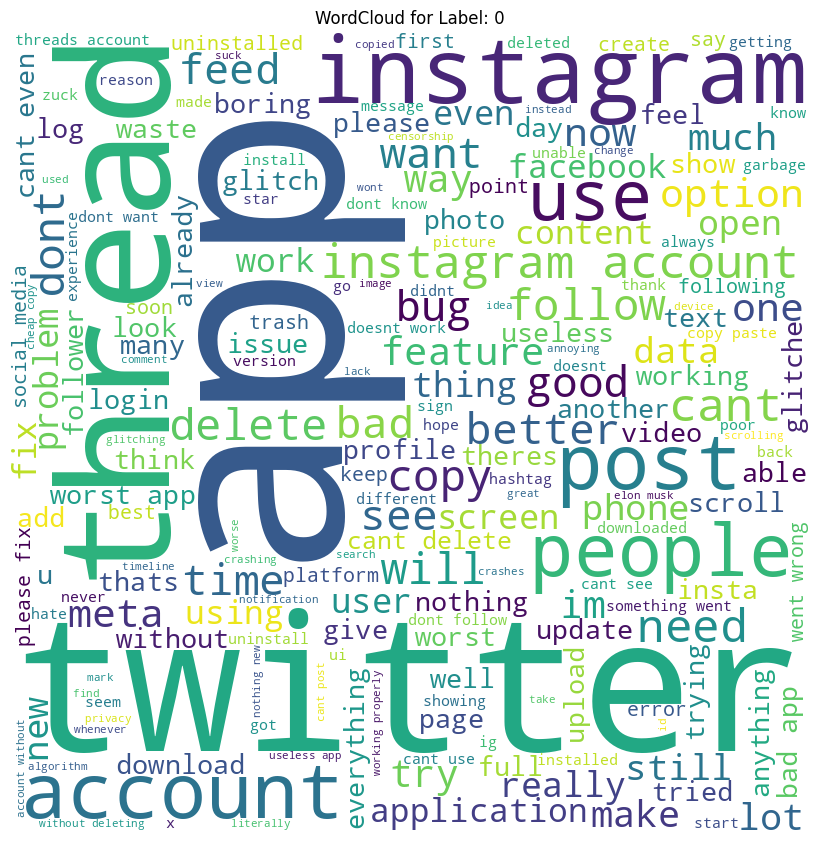

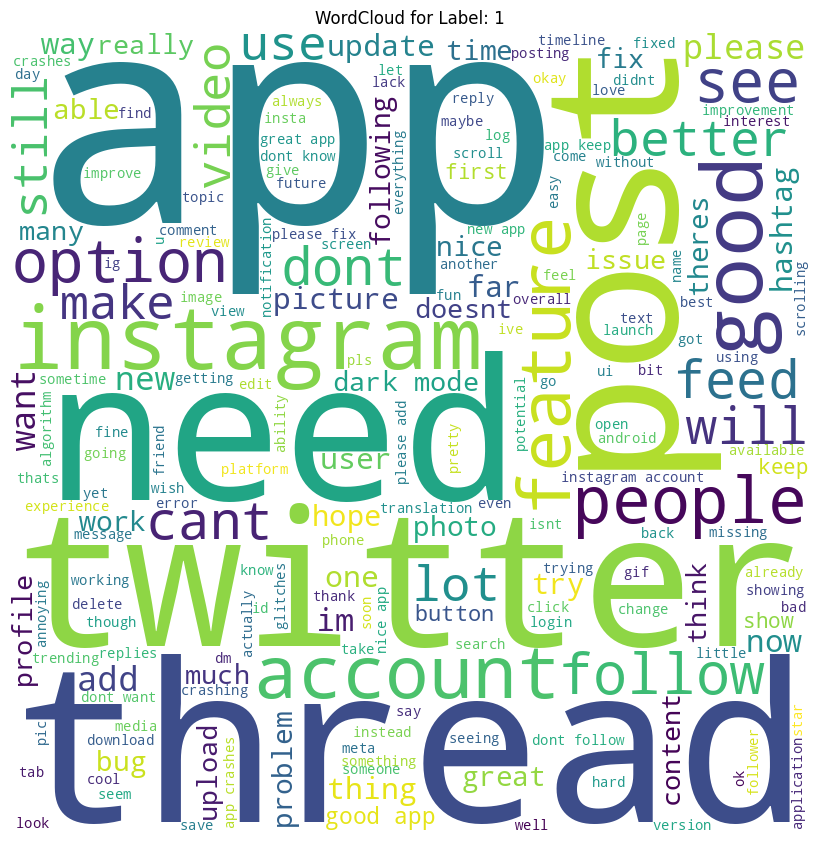

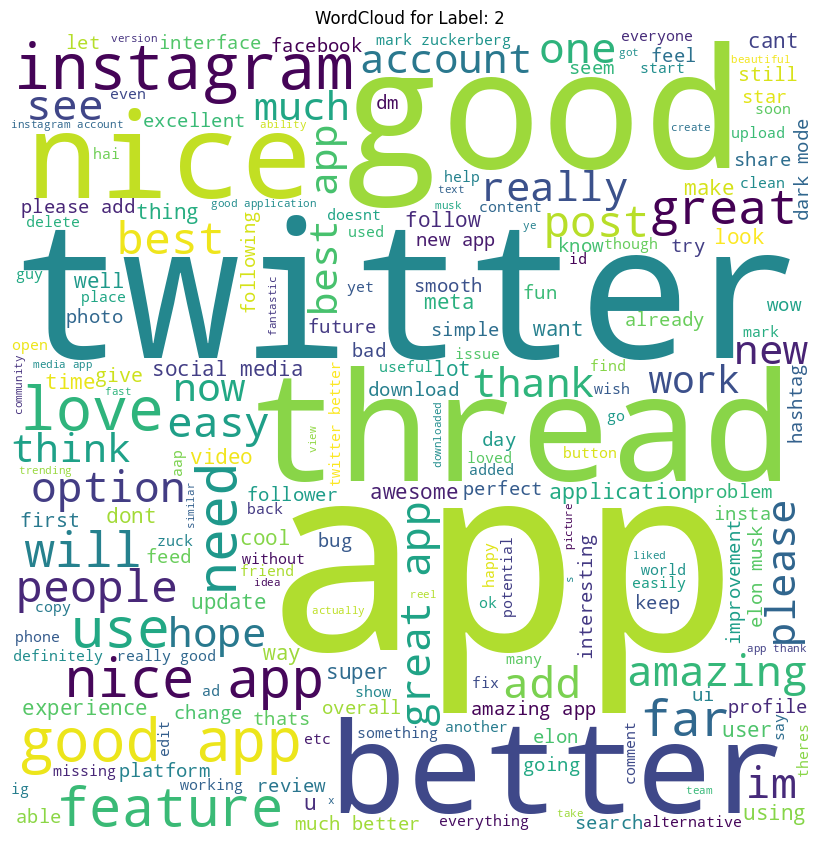

In [13]:
# Membuat WordCloud untuk setiap label
labels = df['label'].unique()
for label in labels:
    text = ' '.join(df[df['label'] == label]['content'].values)
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(f'WordCloud for Label: {label}')
    plt.show()

### **TRAINING/VALIDATION SPLIT**

In [14]:
# Bagi dataset menjadi data train (60%) dan data sisa (40%)
# X_train, X_temp, y_train, y_temp = train_test_split(df.index.values, df.label.values, test_size=0.4, random_state=17, stratify=df.label.values)

# Bagi sisa dataset menjadi data validasi (50%) dan data test (50%)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=17, stratify=y_temp)


In [15]:
# Bagi dataset menjadi data train (80%) dan data sisa (20%)
X_train, X_temp, y_train, y_temp = train_test_split(df.index.values, df.label.values, test_size=0.2, random_state=17, stratify=df.label.values)

# Gunakan SMOTE pada data pelatihan
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(-1, 1), y_train)

# Bentuk kembali data yang telah diresample
X_train_resampled = X_train_resampled.flatten()

# Bagi sisa dataset menjadi data validasi (50%) dan data test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=17, stratify=y_temp)


In [16]:
# Cetak distribusi kelas sebelum SMOTE
print("Distribusi Kelas Sebelum SMOTE:")
print(df.iloc[X_train]['label'].value_counts())

print("Jumlah Sampel Setelah SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Distribusi Kelas Sebelum SMOTE:
0    12562
2    11806
1     2407
Name: label, dtype: int64
Jumlah Sampel Setelah SMOTE:
0    12562
2    12562
1    12562
dtype: int64


In [17]:
# Tambahkan kolom baru "data_type" untuk data test
df['data_type'] = ['not_set'] * df.shape[0]
df.loc[X_test, 'data_type'] = 'test'

In [18]:
# Mengelompokkan nilai kolom 'data_type' di baris yang sesuai dengan indeks X_train, X_val, dan X_test pada DataFrame

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

### **Loading Tokenizer and Encoding our Data**

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [20]:
# Menggunakan tokenizer untuk mengkodekan data setelah SMOTE
encoded_data_train_resampled = tokenizer.batch_encode_plus(
    df.loc[X_train_resampled, 'content'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Menggunakan tokenizer untuk mengkodekan data validasi
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].content.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Menggunakan tokenizer untuk mengkodekan data uji
encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].content.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Mendapatkan input_ids, attention_masks, dan labels untuk data setelah SMOTE
input_ids_train_resampled = encoded_data_train_resampled['input_ids']
attention_masks_train_resampled = encoded_data_train_resampled['attention_mask']
labels_train_resampled = torch.tensor(df.loc[X_train_resampled, 'label'].values)

# Mendapatkan input_ids, attention_masks, dan labels untuk data validasi
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

# Mendapatkan input_ids, attention_masks, dan labels untuk data uji
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df[df.data_type=='test'].label.values)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [21]:
# Membuat objek TensorDataset dari fitur dan label untuk data setelah SMOTE
dataset_train_resampled = TensorDataset(input_ids_train_resampled, attention_masks_train_resampled, labels_train_resampled)

# Membuat objek TensorDataset dari fitur dan label untuk data validasi
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# Membuat objek TensorDataset dari fitur dan label untuk data uji
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)


In [22]:
len(dataset_train_resampled)

37686

In [23]:
len(dataset_val)

3347

In [24]:
len(dataset_test)

3347

### **SETTING UP BERT PRE-TRAINED MODEL**

In [25]:
# Membuat kode unik dari kolom label

possible_labels = df.label.unique()

In [26]:
# Mengonversi label ke kelas index

label_dict = {}
for index, possible_label in enumerate(possible_labels):
  label_dict[possible_label] = index

In [27]:
# Jumlah kelas dalam tugas klasifikasi
num_labels = len(label_dict)

# Menginisialisasi model BERT untuk klasifikasi urutan
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=num_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
params = list(model.named_parameters())  # Mendapatkan Daftar Nama Parameter

print('The BERT model has {:} different named parameters.\n'.format(len(params)))  # Mencetak Jumlah Parameter

print('=== Embedding Layer ===\n')  # Mencetak informasi tentang parameter di lapisan embedding.
for p in params[0:5]:  # Pilih hanya lima parameter pertama untuk contoh, dapat disesuaikan.
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n=== Transformer ===\n')  # Mencetak informasi tentang parameter di lapisan transformer.
for p in params[5:]:  # Mulai dari parameter ke-6 karena BERT memiliki lapisan embedding dan transformer.
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

=== Embedding Layer ===

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

=== Transformer ===

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert

### **CREATING DATA LOADERS**
membuat objek DataLoader untuk mengatur data pelatihan dan validasi dalam bentuk batch.

In [29]:
batch_size = 32

# DataLoader untuk data pelatihan
# DataLoader untuk data setelah SMOTE
dataloader_train_resampled = DataLoader(dataset_train_resampled,
                                        sampler=RandomSampler(dataset_train_resampled),
                                        batch_size=batch_size)

# DataLoader untuk data validasi
dataloader_validation = DataLoader(dataset_val,
                                   sampler=RandomSampler(dataset_val),
                                   batch_size=batch_size)

# DataLoader untuk data uji
dataloader_test = DataLoader(dataset_test,
                              sampler=RandomSampler(dataset_test),
                              batch_size=batch_size)

### **SETTING UP OPTIMISER AND SCHEDULER**
mempersiapkan algoritma optimasi AdamW untuk mengoptimalkan (memperbarui) parameter-parameter model selama pelatihan.

In [30]:
optimizer = AdamW(model.parameters(), # Mendapatkan semua parameter model yang memerlukan pembaruan selama pelatihan
                  lr=1e-5, # Menentukan tingkat pembelajaran (learning rate) untuk optimizer.
                  eps=1e-8) # Menentukan epsilon (ε) atau nilai kecil yang digunakan untuk mencegah pembagian dengan nol dalam algoritma AdamW.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
epochs = 10

# Scheduler untuk data pelatihan
scheduler_train = get_linear_schedule_with_warmup(optimizer,
                                                  num_warmup_steps=0,
                                                  num_training_steps=len(dataloader_train_resampled)*epochs)

# Scheduler untuk data validasi
scheduler_val = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(dataloader_validation)*epochs)

# Scheduler untuk data uji
num_training_steps_test = len(dataloader_test) * epochs
scheduler_test = get_linear_schedule_with_warmup(optimizer,
                                                 num_warmup_steps=0,
                                                 num_training_steps=num_training_steps_test)


### **DEFINING OUR PERFORMANCE METRICS**

In [32]:
# Fungsi precision_score_func digunakan untuk menghitung skor presisi (precision).
def precision_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Mendapatkan kelas prediksi dari vektor prediksi
    labels_flat = labels.flatten()  # Mengambil label sebenarnya dan meratakannya
    return precision_score(labels_flat, preds_flat, average='macro')  # Menghitung presisi dengan skala rata-rata 'macro'.

# Fungsi accuracy_score_func digunakan untuk menghitung skor akurasi (accuracy).
def accuracy_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Mendapatkan kelas prediksi dari vektor prediksi
    labels_flat = labels.flatten()  # Mengambil label sebenarnya dan meratakan mereka
    return accuracy_score(labels_flat, preds_flat)  # Menghitung akurasi.

# Fungsi recall_score_func digunakan untuk menghitung skor recall.
def recall_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Mendapatkan kelas prediksi dari vektor prediksi
    labels_flat = labels.flatten()  # Mengambil label sebenarnya dan meratakan mereka
    return recall_score(labels_flat, preds_flat, average='macro')  # Menghitung recall dengan skala rata-rata 'macro'.

# Fungsi f1_score_func digunakan untuk menghitung skor F1-score.
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Mendapatkan kelas prediksi dari vektor prediksi
    labels_flat = labels.flatten()  # Mengambil label sebenarnya dan meratakan mereka
    return f1_score(labels_flat, preds_flat, average='weighted')  # Menghitung F1-score dengan skala rata-rata 'weighted'.

# Fungsi-fungsi evaluasi tambahan untuk data uji (pengujian).
# Fungsi-fungsi ini serupa dengan yang sebelumnya, tetapi digunakan untuk pengujian (testing) model.
def precision_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, preds_flat, average='macro')

def accuracy_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def recall_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, preds_flat, average='macro')

def f1_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')


In [33]:
def accuracy_per_class_test(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}  # Mengembalikan kamus invers dari kamus label_dict

    # Mengambil prediksi dan label dalam bentuk flat array
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels.flat):  # Iterasi melalui setiap label unik dalam labels
        # Mengambil prediksi dan label yang sesuai dengan label saat ini
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        # Mencetak akurasi per kelas
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}\n')


### **CREATING OUR TRAINING LOOP**

In [34]:
# Periksa ketersediaan GPU
print("GPU Available:", torch.cuda.is_available())

GPU Available: True


In [35]:
# Menentukan perangkat yang digunakan untuk melatih atau menggunakan model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [36]:
# Fungsi evaluate digunakan untuk mengevaluasi model pada data validasi.
def evaluate(dataloader_val):
    model.eval()  # Mengatur model dalam mode evaluasi, menonaktifkan training dropout dan perubahan berat
    loss_val_total = 0  # Inisialisasi total loss untuk data validasi
    predictions, true_vals = [], []  # Inisialisasi list untuk menyimpan prediksi dan label yang sebenarnya

    for batch in dataloader_val:  # Loop melalui batch data validasi
        batch = tuple(b.to(device) for b in batch)  # Mengirim data batch ke perangkat (device) yang sesuai
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}  # Mendapatkan input dan label dari batch
        with torch.no_grad():  # Memastikan perhitungan tidak menyimpan gradien
            outputs = model(**inputs)  # Menggunakan model untuk melakukan prediksi pada data validasi
        loss = outputs.loss  # Mendapatkan loss dari hasil prediksi
        logits = outputs.logits  # Mendapatkan logit (skor) dari hasil prediksi

        loss_val_total += loss.item()  # Menambahkan loss dari batch ke total loss
        logits = logits.detach().cpu().numpy()  # Mengambil hasil prediksi dan mengkonversinya menjadi array NumPy
        labels_ids = inputs['labels'].cpu().numpy()  # Mengambil label yang sebenarnya dan mengkonversinya menjadi array NumPy
        predictions.append(logits)  # Menyimpan hasil prediksi dalam list
        true_vals.append(labels_ids)  # Menyimpan label yang sebenarnya dalam list

    loss_val_avg = loss_val_total / len(dataloader_val)  # Menghitung rata-rata loss pada data validasi

    predictions = np.concatenate(predictions, axis=0)  # Menggabungkan hasil prediksi dari semua batch
    true_vals = np.concatenate(true_vals, axis=0)  # Menggabungkan label yang sebenarnya dari semua batch

    return loss_val_avg, predictions, true_vals  # Mengembalikan rata-rata loss, hasil prediksi, dan label yang sebenarnya

# Fungsi evaluate_test digunakan untuk mengevaluasi model pada data pengujian.
def evaluate_test(dataloader_test):
    model.eval()  # Mengatur model dalam mode evaluasi, menonaktifkan training dropout dan perubahan berat
    loss_test_total = 0  # Inisialisasi total loss untuk data pengujian
    predictions_test, true_vals_test = [], []  # Inisialisasi list untuk menyimpan prediksi dan label yang sebenarnya

    for batch in dataloader_test:  # Loop melalui batch data pengujian
        batch = tuple(b.to(device) for b in batch)  # Mengirim data batch ke perangkat (device) yang sesuai
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}  # Mendapatkan input dan label dari batch
        with torch.no_grad():  # Memastikan perhitungan tidak menyimpan gradien
            outputs = model(**inputs)  # Menggunakan model untuk melakukan prediksi pada data pengujian
        loss = outputs.loss  # Mendapatkan loss dari hasil prediksi
        logits = outputs.logits  # Mendapatkan logit (skor) dari hasil prediksi

        loss_test_total += loss.item()  # Menambahkan loss dari batch ke total loss
        logits = logits.detach().cpu().numpy()  # Mengambil hasil prediksi dan mengkonversinya menjadi array NumPy
        labels_ids = inputs['labels'].cpu().numpy()  # Mengambil label yang sebenarnya dan mengkonversinya menjadi array NumPy
        predictions_test.append(logits)  # Menyimpan hasil prediksi dalam list
        true_vals_test.append(labels_ids)  # Menyimpan label yang sebenarnya dalam list

    loss_test_avg = loss_test_total / len(dataloader_test)  # Menghitung rata-rata loss pada data pengujian

    predictions_test = np.concatenate(predictions_test, axis=0)  # Menggabungkan hasil prediksi dari semua batch
    true_vals_test = np.concatenate(true_vals_test, axis=0)  # Menggabungkan label yang sebenarnya dari semua batch

    return loss_test_avg, predictions_test, true_vals_test  # Mengembalikan rata-rata loss, hasil prediksi, dan label yang sebenarnya


In [37]:
training_status = []  # Inisialisasi list untuk menyimpan status pelatihan

# Inisialisasi list untuk mengumpulkan data metrik
train_losses = []
val_losses = []
test_losses = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
test_f1_scores = []
test_precision_scores = []
test_recall_scores = []
test_accuracy_scores = []

# Loop melalui sejumlah epoch yang ditentukan
for epoch_i in tqdm(range(0, epochs)):
    model.train()  # Model dalam mode pelatihan
    loss_train_total = 0  # Inisialisasi total loss pelatihan

    # Bar progress untuk menampilkan perkembangan pelatihan
    progress_bar = tqdm(dataloader_train_resampled, desc='Epoch {:1d}'.format(epoch_i + 1), leave=True, disable=False)

    # Loop melalui batch data pelatihan
    for batch in progress_bar:
        model.zero_grad()  # Mengatur gradien pada nol
        batch = tuple(b.to(device) for b in batch)  # Mengirim data batch ke perangkat (device) yang sesuai
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)  # Menggunakan model untuk melakukan prediksi pada data pelatihan
        loss = outputs[0]  # Mendapatkan loss dari hasil prediksi
        loss_train_total += loss.item()
        loss.backward()  # Menghitung gradien loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Menggunakan clipping gradient untuk mencegah gradien eksplosif
        optimizer.step()  # Melakukan optimisasi dengan langkah yang dihitung
        scheduler_train.step()  # Menggunakan scheduler_train untuk pelatihan (misalnya, penurunan suku learning rate)
        progress_bar.set_postfix({'training_loss': '{0:.2f}'.format(loss.item() / len(batch))})  # Menampilkan loss saat ini

    # Menyimpan model setiap epoch
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch_i}.model')

    tqdm.write(f'\nEpoch {epoch_i}')
    loss_train_avg = loss_train_total / len(dataloader_train_resampled)
    tqdm.write(f'Training loss: {loss_train_avg}')

    # Evaluasi model pada data validasi
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_precision = precision_score_func(predictions, true_vals)
    val_recall = recall_score_func(predictions, true_vals)
    val_accuracy = accuracy_score_func(predictions, true_vals)

    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score: {val_f1}')
    tqdm.write(f'Precision Score: {val_precision}')
    tqdm.write(f'Recall Score: {val_recall}')
    tqdm.write(f'Accuracy Score: {val_accuracy}')

    # Evaluasi model pada data uji
    test_loss, test_predictions, test_true_vals = evaluate_test(dataloader_test)
    test_f1 = f1_score_func_test(test_predictions, test_true_vals)
    test_precision = precision_score_func_test(test_predictions, test_true_vals)
    test_recall = recall_score_func_test(test_predictions, test_true_vals)
    test_accuracy = accuracy_score_func_test(test_predictions, test_true_vals)

    tqdm.write(f'Test loss: {test_loss}')
    tqdm.write(f'Test F1 Score: {test_f1}')
    tqdm.write(f'Test Precision Score: {test_precision}')
    tqdm.write(f'Test Recall Score: {test_recall}')
    tqdm.write(f'Test Accuracy Score: {test_accuracy}')

    # Menambahkan metrik pelatihan, validasi, dan uji ke dalam list
    train_losses.append(loss_train_total / len(dataloader_train_resampled))
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    f1_scores.append(val_f1)
    precision_scores.append(val_precision)
    recall_scores.append(val_recall)
    accuracy_scores.append(val_accuracy)
    test_f1_scores.append(test_f1)
    test_precision_scores.append(test_precision)
    test_recall_scores.append(test_recall)
    test_accuracy_scores.append(test_accuracy)

    # Menambahkan status pelatihan ke dalam daftar
    training_status.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'F1 Score': val_f1,
            'Precision Score': val_precision,
            'Recall Score': val_recall,
            'Accuracy Score': val_accuracy,
            'Test Loss': test_loss,
            'Test F1 Score': test_f1,
            'Test Precision Score': test_precision,
            'Test Recall Score': test_recall,
            'Test Accuracy Score': test_accuracy
        }
    )


  0%|          | 0/10 [20:20<?, ?it/s]


Epoch 0
Training loss: 0.5616798184192241


  0%|          | 0/10 [20:59<?, ?it/s]

Validation loss: 0.4556827982266744
F1 Score: 0.832627002027013
Precision Score: 0.728747305143321
Recall Score: 0.7228307276707394
Accuracy Score: 0.8338810875410816


 10%|█         | 1/10 [21:22<3:12:22, 1282.52s/it]

Test loss: 0.4643119800658453
Test F1 Score: 0.829604124606345
Test Precision Score: 0.7329236942274079
Test Recall Score: 0.7234274082871038
Test Accuracy Score: 0.8314908873618165



 10%|█         | 1/10 [41:47<3:12:22, 1282.52s/it]


Epoch 1
Training loss: 0.39225582031498335


 10%|█         | 1/10 [42:26<3:12:22, 1282.52s/it]

Validation loss: 0.39739711050476345
F1 Score: 0.8566271609314992
Precision Score: 0.7933695731999205
Recall Score: 0.73925252587981
Accuracy Score: 0.863161039737078


 20%|██        | 2/10 [42:49<2:51:21, 1285.24s/it]

Test loss: 0.421604747289703
Test F1 Score: 0.8560516550851962
Test Precision Score: 0.7953624052119004
Test Recall Score: 0.7488409158026306
Test Accuracy Score: 0.8610696145802211



 20%|██        | 2/10 [1:03:15<2:51:21, 1285.24s/it]


Epoch 2
Training loss: 0.2836265265024528


 20%|██        | 2/10 [1:03:54<2:51:21, 1285.24s/it]

Validation loss: 0.38386652249665487
F1 Score: 0.876891914471355
Precision Score: 0.8198622478275324
Recall Score: 0.7824020569295445
Accuracy Score: 0.8801912160143412


 30%|███       | 3/10 [1:04:17<2:30:05, 1286.44s/it]

Test loss: 0.4130188416867029
Test F1 Score: 0.8735470021928764
Test Precision Score: 0.8214231495219645
Test Recall Score: 0.7953094659181562
Test Accuracy Score: 0.8754108156558111



 30%|███       | 3/10 [1:24:42<2:30:05, 1286.44s/it]


Epoch 3
Training loss: 0.21693668789933918


 30%|███       | 3/10 [1:25:21<2:30:05, 1286.44s/it]

Validation loss: 0.40929795847762196
F1 Score: 0.8872105836516412
Precision Score: 0.8498676759991565
Recall Score: 0.801070101322698
Accuracy Score: 0.8903495667762175


 40%|████      | 4/10 [1:25:44<2:08:39, 1286.63s/it]

Test loss: 0.45475902933449974
Test F1 Score: 0.8765944749028534
Test Precision Score: 0.8252288306747283
Test Recall Score: 0.7998069331971086
Test Accuracy Score: 0.8783985658798924



 40%|████      | 4/10 [1:46:08<2:08:39, 1286.63s/it]


Epoch 4
Training loss: 0.1740244438639306


 40%|████      | 4/10 [1:46:48<2:08:39, 1286.63s/it]

Validation loss: 0.43031442399535863
F1 Score: 0.8925039341305759
Precision Score: 0.8438779863051747
Recall Score: 0.8172987533185325
Accuracy Score: 0.8942336420675232


 50%|█████     | 5/10 [1:47:11<1:47:13, 1286.70s/it]

Test loss: 0.4916581760914553
Test F1 Score: 0.8812424483052326
Test Precision Score: 0.8229155234981328
Test Recall Score: 0.8122819924547583
Test Accuracy Score: 0.88198386614879



 50%|█████     | 5/10 [2:07:36<1:47:13, 1286.70s/it]


Epoch 5
Training loss: 0.15024315035611024


 50%|█████     | 5/10 [2:08:15<1:47:13, 1286.70s/it]

Validation loss: 0.43051105381122656
F1 Score: 0.8963995586954391
Precision Score: 0.8674530167379721
Recall Score: 0.8215852192258396
Accuracy Score: 0.898715267403645


 60%|██████    | 6/10 [2:08:38<1:25:47, 1286.82s/it]

Test loss: 0.49277506034289087
Test F1 Score: 0.8819483468533522
Test Precision Score: 0.8371748078819072
Test Recall Score: 0.8116750449057135
Test Accuracy Score: 0.8834777412608306



 60%|██████    | 6/10 [2:29:07<1:25:47, 1286.82s/it]


Epoch 6
Training loss: 0.12760631939758355


 60%|██████    | 6/10 [2:29:47<1:25:47, 1286.82s/it]

Validation loss: 0.4606671847580444
F1 Score: 0.8977529868515225
Precision Score: 0.8514672635782813
Recall Score: 0.8297648779797792
Accuracy Score: 0.8990140424260532


 70%|███████   | 7/10 [2:30:10<1:04:25, 1288.50s/it]

Test loss: 0.5352663493227391
Test F1 Score: 0.8849612786236214
Test Precision Score: 0.8292966184080036
Test Recall Score: 0.8244095238209931
Test Accuracy Score: 0.8852703913952794



 70%|███████   | 7/10 [2:50:35<1:04:25, 1288.50s/it]


Epoch 7
Training loss: 0.11589626533414928


 70%|███████   | 7/10 [2:51:14<1:04:25, 1288.50s/it]

Validation loss: 0.46644627185804505
F1 Score: 0.8999694179936003
Precision Score: 0.8558326342277757
Recall Score: 0.8306726306813249
Accuracy Score: 0.9014042426053182


 80%|████████  | 8/10 [2:51:37<42:56, 1288.25s/it]  

Test loss: 0.5518006676719303
Test F1 Score: 0.8830521388490483
Test Precision Score: 0.8306736987071348
Test Recall Score: 0.818967074827092
Test Accuracy Score: 0.8837765162832387



 80%|████████  | 8/10 [3:12:03<42:56, 1288.25s/it]


Epoch 8
Training loss: 0.10531956829242914


 80%|████████  | 8/10 [3:12:43<42:56, 1288.25s/it]

Validation loss: 0.4963844180284511
F1 Score: 0.8991818157874465
Precision Score: 0.8522441367101706
Recall Score: 0.8300360934438965
Accuracy Score: 0.9005079175380938


 90%|█████████ | 9/10 [3:13:06<21:28, 1288.28s/it]

Test loss: 0.581172324238079
Test F1 Score: 0.8841411112151075
Test Precision Score: 0.8320622234202665
Test Recall Score: 0.8231033112505054
Test Accuracy Score: 0.8846728413504631



 90%|█████████ | 9/10 [3:33:30<21:28, 1288.28s/it]


Epoch 9
Training loss: 0.10076989973798403


 90%|█████████ | 9/10 [3:34:10<21:28, 1288.28s/it]

Validation loss: 0.49804086399575076
F1 Score: 0.8999932279227995
Precision Score: 0.855095799609248
Recall Score: 0.8306999437064179
Accuracy Score: 0.9014042426053182


100%|██████████| 10/10 [3:34:33<00:00, 1287.33s/it]

Test loss: 0.585883785974944
Test F1 Score: 0.883366788790302
Test Precision Score: 0.828074671169429
Test Recall Score: 0.821557741721692
Test Accuracy Score: 0.8837765162832387


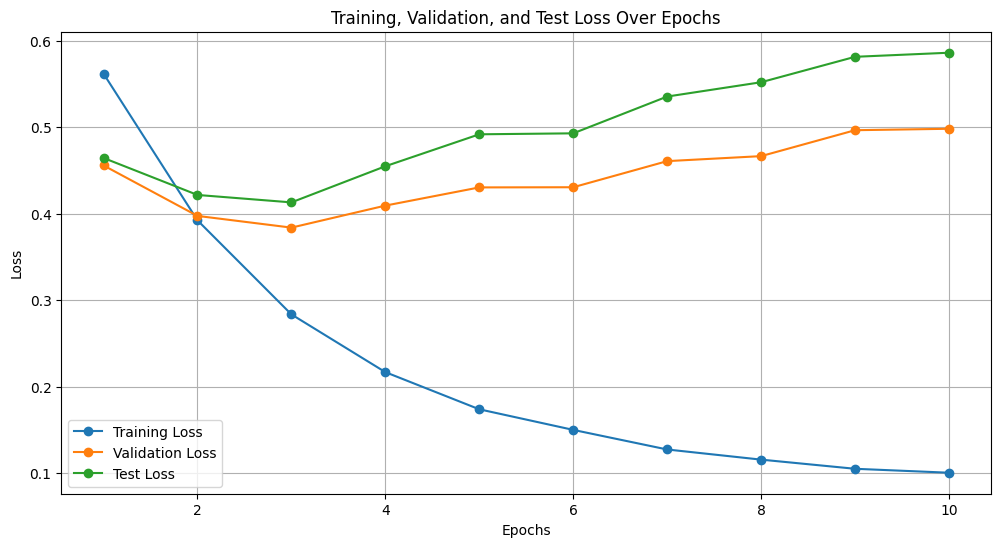

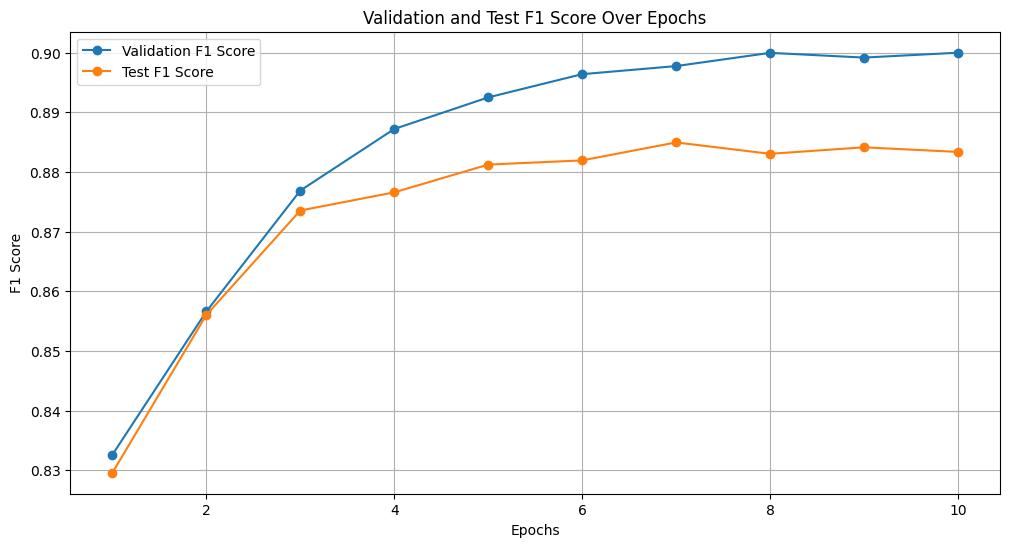

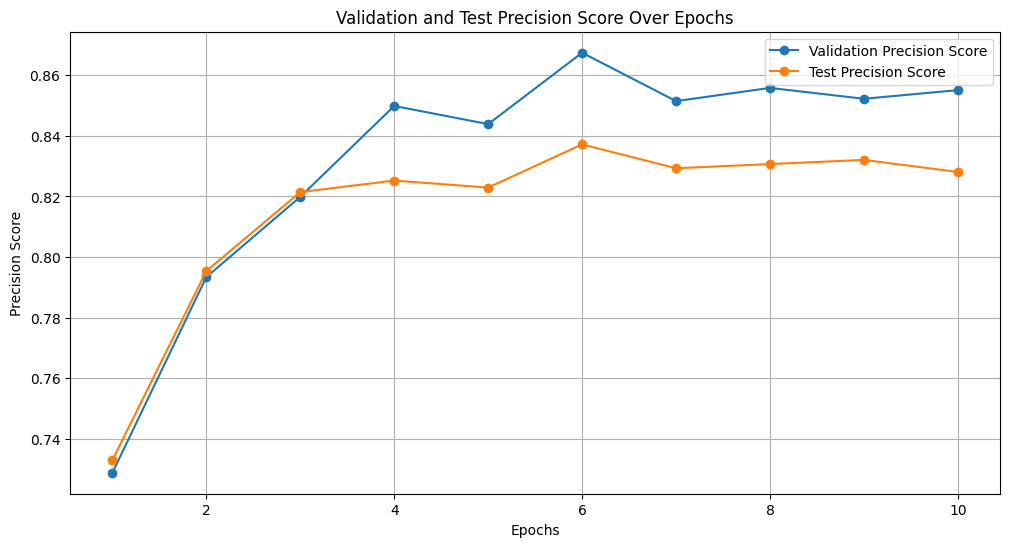

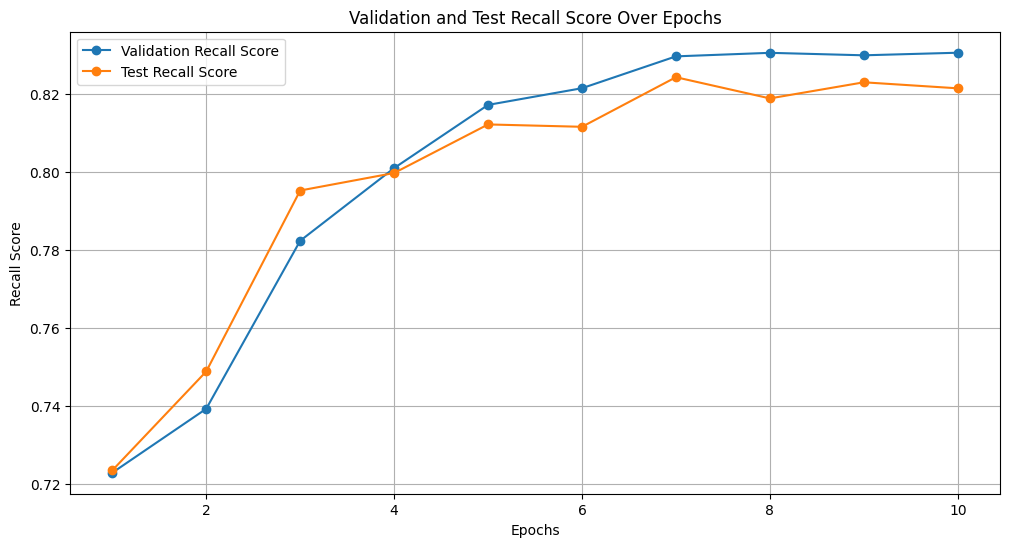

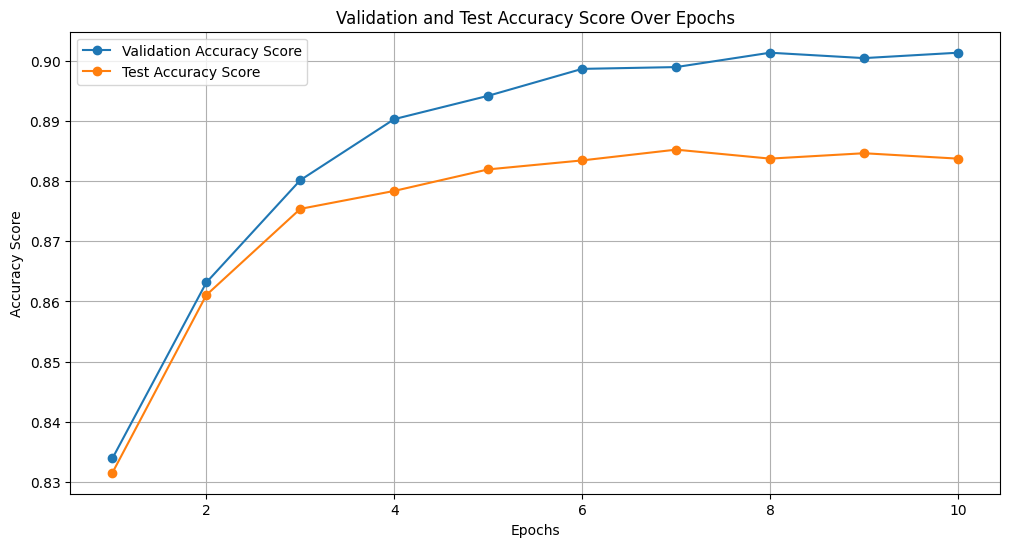

In [38]:
# Menggunakan range(1, len(train_losses) + 1) untuk sumbu x
epochs = range(1, len(train_losses) + 1)

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, f1_scores, label='Validation F1 Score', marker='o')
plt.plot(epochs, test_f1_scores, label='Test F1 Score', marker='o')
plt.title('Validation and Test F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_scores, label='Validation Precision Score', marker='o')
plt.plot(epochs, test_precision_scores, label='Test Precision Score', marker='o')
plt.title('Validation and Test Precision Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, recall_scores, label='Validation Recall Score', marker='o')
plt.plot(epochs, test_recall_scores, label='Test Recall Score', marker='o')
plt.title('Validation and Test Recall Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy_scores, label='Validation Accuracy Score', marker='o')
plt.plot(epochs, test_accuracy_scores, label='Test Accuracy Score', marker='o')
plt.title('Validation and Test Accuracy Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
# Menggunakan training_status yang sudah ada untuk hasil evaluasi
results = []
for epoch_result in training_status:
    epoch_metrics = {
        'Epoch': epoch_result['epoch'],
        'Training Loss': epoch_result['Training Loss'],
        'Validation Loss': epoch_result['Valid. Loss'],
        'F1 Score (Val)': epoch_result['F1 Score'],
        'Precision Score (Val)': epoch_result['Precision Score'],
        'Recall Score (Val)': epoch_result['Recall Score'],
        'Accuracy Score (Val)': epoch_result['Accuracy Score'],
        'Test Loss': epoch_result['Test Loss'],
        'Test F1 Score': epoch_result['Test F1 Score'],
        'Test Precision Score': epoch_result['Test Precision Score'],
        'Test Recall Score': epoch_result['Test Recall Score'],
        'Test Accuracy Score': epoch_result['Test Accuracy Score']
    }
    results.append(epoch_metrics)

# Buat DataFrame dari hasil evaluasi
df = pd.DataFrame(results)

# Tampilkan DataFrame
print(df)


   Epoch  Training Loss  Validation Loss  F1 Score (Val)  \
0      1       0.561680         0.455683        0.832627   
1      2       0.392256         0.397397        0.856627   
2      3       0.283627         0.383867        0.876892   
3      4       0.216937         0.409298        0.887211   
4      5       0.174024         0.430314        0.892504   
5      6       0.150243         0.430511        0.896400   
6      7       0.127606         0.460667        0.897753   
7      8       0.115896         0.466446        0.899969   
8      9       0.105320         0.496384        0.899182   
9     10       0.100770         0.498041        0.899993   

   Precision Score (Val)  Recall Score (Val)  Accuracy Score (Val)  Test Loss  \
0               0.728747            0.722831              0.833881   0.464312   
1               0.793370            0.739253              0.863161   0.421605   
2               0.819862            0.782402              0.880191   0.413019   
3              

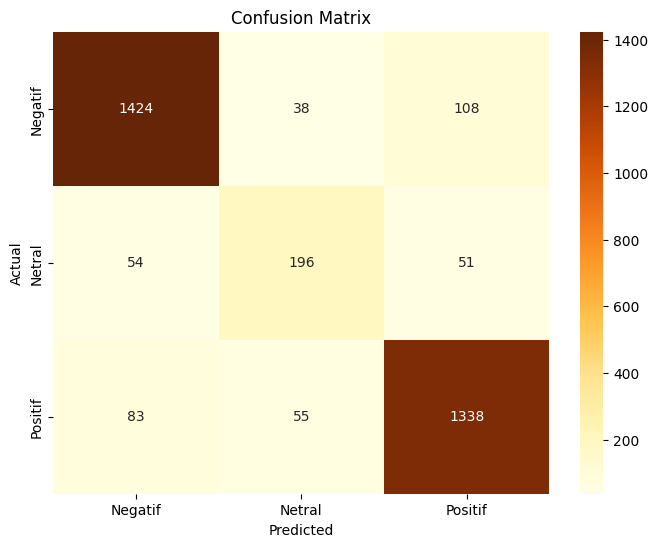

In [40]:
# Evaluasi model pada data uji
test_loss, test_predictions, test_true_vals = evaluate_test(dataloader_test)

# Membuat confusion matrix
confusion = confusion_matrix(test_true_vals, test_predictions.argmax(axis=1))

# Daftar label kelas
class_labels = ["Negatif", "Netral", "Positif"]

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='YlOrBr', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [41]:
# Set model ke mode evaluasi
model.eval()

# Inisialisasi list untuk menyimpan hasil prediksi dan label sebenarnya
all_predictions = []
all_true_vals = []

# Loop melalui batch data uji
for batch in tqdm(dataloader_test, desc='Evaluating'):
    batch = tuple(b.to(device) for b in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
    with torch.no_grad():
        outputs = model(**inputs)  # Menggunakan model untuk melakukan prediksi pada data uji
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)  # Mengambil kelas dengan nilai probabilitas tertinggi
    all_predictions.extend(predictions.cpu().numpy())
    all_true_vals.extend(batch[2].cpu().numpy())

# Tampilkan hasil prediksi dan label yang sebenarnya
for i in range(len(all_predictions)):
    print(f'Prediksi: {all_predictions[i]}, Label Sebenarnya: {all_true_vals[i]}')


Evaluating: 100%|██████████| 105/105 [00:23<00:00,  4.52it/s]


Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 1, Label Sebenarnya: 0
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 1, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 2
Prediksi: 1, Label Sebenarnya: 1
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 

In [42]:
import pandas as pd

# Buat DataFrame dari hasil prediksi dan label sebenarnya
df_results = pd.DataFrame({
    'Prediksi': all_predictions,
    'Label Sebenarnya': all_true_vals
})

# Tampilkan DataFrame sebagai tabel
print(df_results)


      Prediksi  Label Sebenarnya
0            0                 0
1            2                 2
2            0                 0
3            0                 0
4            2                 2
...        ...               ...
3342         2                 2
3343         2                 2
3344         2                 2
3345         0                 0
3346         1                 1

[3347 rows x 2 columns]
